In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import log
import numpy as np
from typing import List
from analysis.ngram import calculate_avg_ll, calculate_avg_ln
from analysis.optimization import optimize_em, optimize_gd, GradientDescent, EM
from analysis.plot_utils import plt, legend_opts, savefig
from matplotlib.animation import FuncAnimation

## Combine models sequentially

In [3]:
train_prob_matrix = np.load('../data/train_prob_matrix.npy')
dev1_prob_matrix = np.load('../data/dev1_prob_matrix.npy')
dev2_prob_matrix = np.load('../data/dev2_prob_matrix.npy')

In [4]:
dev_prob_matrix = np.vstack([dev1_prob_matrix, dev2_prob_matrix])
dev_prob_matrix.shape

(803176, 6)

In [5]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []
labels = []
label = ''

ngram_combo = []
for n in range(6):
    ngram_combo.append(n)
    train_avg_lls.append(calculate_avg_ln(train_prob_matrix[:, ngram_combo]))
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, ngram_combo]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, ngram_combo]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, ngram_combo]))
    
    label += f'{n}\n'
    labels.append(label)
labels[0] = '0\n(uniform)'

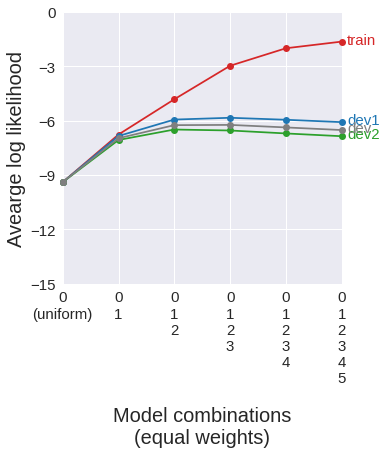

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngram_combo, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngram_combo, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngram_combo, dev2_avg_lls, '-o', color='tab:green', clip_on=False)
ax.plot(ngram_combo, dev_avg_lls, '-o', color='tab:gray', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)
ax.text(5.1, dev_avg_lls[-1]+0.1, s='dev', va='center', color='tab:gray', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('Model combinations\n(equal weights)')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()

savefig(fig, 'what_to_combine.png')

## Interpolating 2 models

In [7]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
dev1_avg_lls = []
dev2_avg_lls = []
dev_avg_lls = []

for unigram_weight in unigram_weights:
    dev1_avg_lls.append(calculate_avg_ln(dev1_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev2_avg_lls.append(calculate_avg_ln(dev2_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))
    dev_avg_lls.append(calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]))

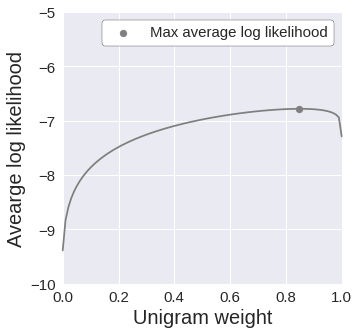

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

# ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
# ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)

# ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
# ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.legend(**legend_opts)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Avearge log likelihood')

savefig(fig, 'avg_ll_two_models.png')

## Gradient descent

### Animate gradient descent progress

Run gradient descent for first 10 iterations (technically 11)

In [9]:
optimize_gd(dev_prob_matrix[:, [0, 1]],
            init_weights=[0.1, 0.9],
            learning_rate=0.1,
            n_iter=10)

array([0.14948199, 0.85051801])

In [10]:
n_iter = 11
iter_colors = plt.cm.viridis_r(np.linspace(0.2, 1, n_iter))

In [11]:
gd = GradientDescent()
gd.fit(dev_prob_matrix[:, [0, 1]], learning_rate=0.1, n_iter=n_iter, init_weights=[0.9, 0.1])
gd.weights

array([0.15002533, 0.84997467])

In [12]:
def update_gd(fig, ax, iteration):
    fig.suptitle(f'Iteration {iteration}', fontsize=20)
    ax.lines = [ax.lines[0]]
    ax.collections = [ax.collections[0]]
        
    tangent_length = 0.15
    
    info = gd.tracked_info[iteration]
    unigram_weight = info['weights'][1]
    unigram_gradient = info['gradients'][0]
    avg_ll = info['avg_ll']
    
    lower_unigram_weight, upper_unigram_weight = unigram_weight - tangent_length, unigram_weight + tangent_length
    lower_ll, upper_ll = avg_ll - unigram_gradient * tangent_length, avg_ll + unigram_gradient * tangent_length
    
    # Plot current point
    ax.scatter(unigram_weight, avg_ll, color=iter_colors[iteration])
    
    # Plot tangent line to objective function
    ax.plot([lower_unigram_weight, upper_unigram_weight], [lower_ll, upper_ll], color=iter_colors[iteration])
    
    # Plot trace line up to current point
    ax.vlines(unigram_weight, -10, avg_ll, colors=iter_colors[iteration], linestyles='dashed')

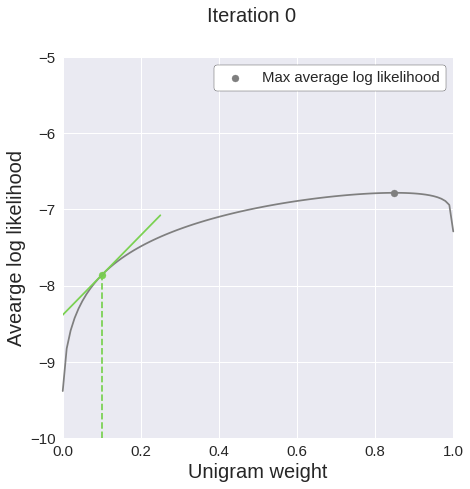

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')
ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)

ax.legend(**legend_opts)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Avearge log likelihood')

anim = FuncAnimation(fig, lambda iteration: update_gd(fig, ax, iteration), 
                     frames=range(n_iter), interval=300, repeat=True)
anim.save('../viz/gradient_descent.mp4', writer='ffmpeg')

## Expectation-maximation algorithm

### High-level explanation

Two-model example (uniform + unigram)

In [14]:
def calculate_posterior_probs(prob_matrix, weights):
    """Calculate posterior weights for a unigram weight at the current iteration"""
    weighted_probs = prob_matrix * weights
    total_probs = weighted_probs.sum(axis=1, keepdims=True)
    posterior_probs = weighted_probs / total_probs
    return posterior_probs

In [15]:
def calculate_lower_bound(prob_matrix, unigram_weight, unigram_step_weight):
    """Calculate lower bound value to each unigram weight
    (parametized by posterior weights corresponding to unigram weight at current iteration).
    This is used to plot the lower bound by inputting an array of unigram weights."""
    true_weights = [1 - unigram_weight, unigram_weight]
    step_weights = [1 - unigram_step_weight, unigram_step_weight]
    posterior_probs = calculate_posterior_probs(prob_matrix, step_weights)
    with np.errstate(invalid='ignore'):
        lower_bound_per_model = posterior_probs * np.log(prob_matrix * true_weights / posterior_probs)
        # Convert any invalid log probabilities (such as prob = 0 -> log prob = -inf) into 0
        # This won't affect the lower bound, since any models whose prob = 0
        # should not be included in the lower bound in the first place
        lower_bound_per_model[np.isnan(lower_bound_per_model)] = 0
        lower_bound_ll = np.sum(lower_bound_per_model, axis=1)
        lower_bound_avg_ll = lower_bound_ll.mean()
    return lower_bound_avg_ll

In [16]:
def construct_lower_bound(prob_matrix, unigram_weights, unigram_step_weight):
    """Construct lower bound for an array of unigram weights, and tight at specified unigram weight at a given step"""
    return [calculate_lower_bound(prob_matrix, unigram_weight, unigram_step_weight) for unigram_weight in unigram_weights]

Step 1: Initialize starting weights

In [17]:
dev_lower_bound_avg_lls = []

unigram_weight0 = 0.1
avg_ll0 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight0, unigram_weight0])

unigram_weights = np.linspace(0.0001, 1-0.0001, 100)
objective_function = [calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
argmax_objective_function, max_objective_function = unigram_weights[np.argmax(objective_function)], np.max(objective_function)

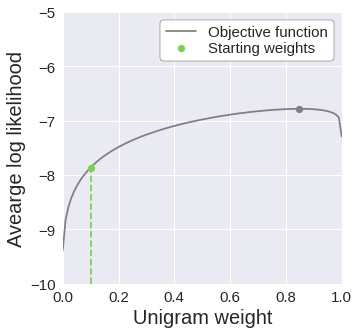

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0, color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color=iter_colors[0], linestyles='dashed')
ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Avearge log likelihood')
savefig(fig, 'e1.png')

Step 2: Construct lower bound to objective function that is tight at starting weights (E-step)

In [19]:
lower_bounds0 = construct_lower_bound(dev_prob_matrix[:, [0, 1]], unigram_weights, unigram_weight0)

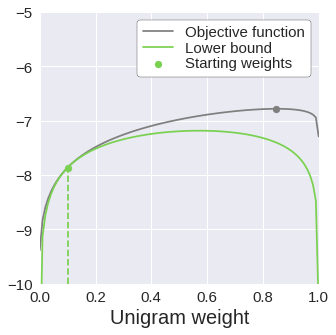

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0, color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color=iter_colors[0], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bounds0, color=iter_colors[0], label='Lower bound')
ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram weight')
savefig(fig, 'e2.png')

**Step 3**: Find weights that maximize lower bound from step 2 and update weights to these values

In [21]:
unigram_weight1, lower_bound1 = unigram_weights[np.argmax(lower_bounds0)], np.max(lower_bounds0)

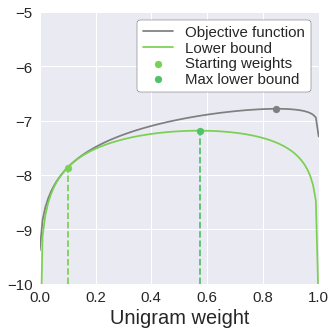

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0, color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, iter_colors[0], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bounds0, color=iter_colors[0], label='Lower bound')

# Plot max lower bound
ax.scatter(unigram_weight1, lower_bound1, color=iter_colors[1], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight1, -10, lower_bound1, color=iter_colors[1], linestyles='dashed')

ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram weight')
savefig(fig, 'e3.png')

**Step 4**: Repeat step 2 and 3

In [23]:
lower_bounds1 = construct_lower_bound(dev_prob_matrix[:, [0, 1]], unigram_weights, unigram_weight1)
avg_ll1 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight1, unigram_weight1])
unigram_weight2, lower_bound2 = unigram_weights[np.argmax(lower_bounds1)], np.max(lower_bounds1)

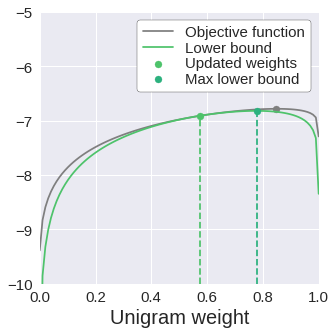

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot updated weights
ax.scatter(unigram_weight1, avg_ll1, color=iter_colors[1], label='Updated weights', zorder=10)
ax.vlines(unigram_weight1, -10, avg_ll1, color=iter_colors[1], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bounds1, color=iter_colors[1], label='Lower bound')

# Plot (new) max lower bound
ax.scatter(unigram_weight2, lower_bound2, color=iter_colors[2], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight2, -10, lower_bound2, color=iter_colors[2], linestyles='dashed')

ax.legend(**legend_opts)

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram weight')
savefig(fig, 'e4.png')

### Why does the lower bound need to be tight?

Tight lower bound

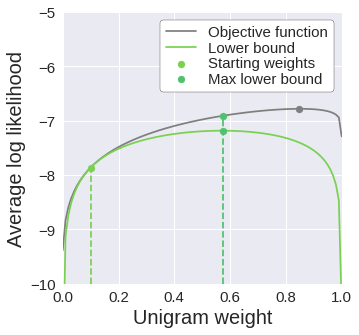

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weight
ax.scatter(unigram_weight0, avg_ll0, color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, iter_colors[0], linestyles='dashed')

# Plot lower bound
ax.plot(unigram_weights, lower_bounds0, color=iter_colors[0], label='Lower bound')

# Plot max lower bound
ax.scatter(unigram_weight1, lower_bound1, color=iter_colors[1], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight1, -10, avg_ll1, color=iter_colors[1], linestyles='dashed')

# Plot average log likelihood of max lower bound
ax.scatter(unigram_weight1, avg_ll1, color=iter_colors[1], zorder=10)

ax.legend(**legend_opts, loc='upper right')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Average log likelihood')
savefig(fig, 'tight_lower_bound.png')

Lose lower bound

In [26]:
unigram_weight_loose = 0.9999

# Create tight lower bound at 0.9, then flip it horizontally and shift down to create loose lowerbound
lower_bounds_loose0 = construct_lower_bound(dev_prob_matrix[:, [0, 1]], unigram_weights, unigram_weight_loose)
lower_bounds_loose0 = np.array(lower_bounds_loose0[::-1]) - 2

# Record lower bound value at starting weight
lower_bound_loose0 = calculate_lower_bound(dev_prob_matrix[:, [0, 1]], 1-unigram_weight0, unigram_weight_loose) - 2

# Record weights that maximizes lower bound
unigram_weight_loose1, lower_bound_loose1 = unigram_weights[np.argmax(lower_bounds_loose0)], np.max(lower_bounds_loose0)

# Record objective function at lower bound-maximizing weights
avg_ll_loose1 = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], weights=[1-unigram_weight_loose1, unigram_weight_loose1])

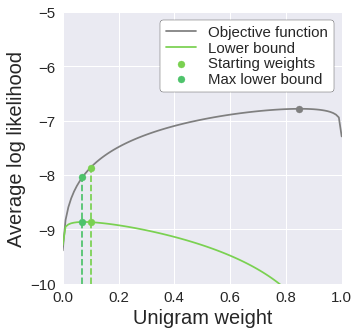

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot objective function
ax.plot(unigram_weights, objective_function, color='tab:gray', label='Objective function')
ax.scatter(argmax_objective_function, max_objective_function, color='tab:gray')

# Plot starting weights
ax.scatter(unigram_weight0, avg_ll0, color=iter_colors[0], label='Starting weights', zorder=10)
ax.vlines(unigram_weight0, -10, avg_ll0, color=iter_colors[0], linestyles='dashed')

# Plot loose lower bound
ax.plot(unigram_weights, lower_bounds_loose0, color=iter_colors[0], label='Lower bound')

# Plot average log likelihood of starting weight at loose lower bound
ax.scatter(unigram_weight0, lower_bound_loose0, color=iter_colors[0])

# Plot max lower bound
ax.scatter(unigram_weight_loose1, lower_bound_loose1, color=iter_colors[1], label='Max lower bound', zorder=10)
ax.vlines(unigram_weight_loose1, -10, avg_ll_loose1, color=iter_colors[1], linestyles='dashed')

# Plot average log likelihood of max lower bound
ax.scatter(unigram_weight_loose1, avg_ll_loose1, color=iter_colors[1], zorder=10)

ax.legend(**legend_opts, loc='upper right')

ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Average log likelihood')
savefig(fig, 'loose_lower_bound.png')

### Jensen's inequality

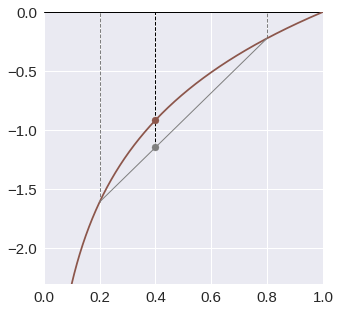

In [28]:
xs = np.linspace(0.1, 1, 1000)
ys = np.log(xs)

fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='black', lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(log(0.1), 0)

def get_secant_value(x, x_start, x_end):
    return log(x_start) + (log(x_end) - log(x_start)) * (x - x_start) / (x_end - x_start)
# Log
ax.plot(xs, ys, zorder=11, color='tab:brown')

# Secant line
ax.plot([0.2, 0.8], [log(0.2), log(0.8)], color='tab:gray', lw=1, zorder=11)

# 
ax.scatter(0.4, log(0.4), zorder=12, color='tab:brown')
secant_at_04 = get_secant_value(0.4, x_start=0.2, x_end=0.8)
ax.scatter(0.4, secant_at_04, color='tab:gray', zorder=12)
ax.vlines(0.2, log(0.2), 0, color='tab:gray', lw=1, ls='--', zorder=10)
ax.vlines(0.8, log(0.8), 0, color='tab:gray', lw=1, ls='--', zorder=10)
ax.vlines(0.4, secant_at_04, 0, color='black', lw=1, ls='--', zorder=10)

savefig(fig, 'log_jensen.png')

### Lower bound as expectation

In [29]:
optimize_gd(prob_matrix=dev_prob_matrix[:, [0, 1]],
            learning_rate=0.1,
            n_iter=10,
            init_weights=[0.1, 0.9])

array([0.14948199, 0.85051801])

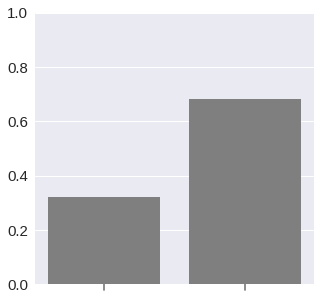

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar([0, 1], [0.32, 0.68], color='tab:gray')
ax.set_xticks([])
ax.set_ylim(0, 1)

ax.axvline(0, -0.02, 0, clip_on=False, color='tab:gray')
ax.axvline(1, -0.02, 0, clip_on=False, color='tab:gray')

savefig(fig, 'z_dist.png')

### Code EM algorithm

In [31]:
optimize_em(prob_matrix=dev_prob_matrix[:, [0, 1]],
            n_iter=10,
            init_weights=[0.9, 0.1])

array([0.14950068, 0.85049932])

In [32]:
n_iter = 11
em = EM()
em.fit(dev_prob_matrix[:, [0, 1]], init_weights=[0.9, 0.1], n_iter=n_iter)

In [33]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)

In [34]:
def update_em(fig, ax, iteration):
    print(iteration)
    fig.suptitle(f'Iteration {iteration}', fontsize=20)
    ax.collections = [ax.collections[0]]
    ax.lines = [ax.lines[0]]
    
    unigram_step_weight = em.tracked_info[iteration]['weights'][1]
    avg_ll = calculate_avg_ln(dev_prob_matrix[:, [0, 1]], [1 - unigram_step_weight, unigram_step_weight])
    
    # Plot current point
    ax.scatter(unigram_step_weight, avg_ll, color=iter_colors[iteration])
    
    # Plot lower bound that is tight against objective function at current point
    lower_bounds = construct_lower_bound(dev_prob_matrix[:, [0, 1]], unigram_weights, unigram_step_weight)
    ax.plot(unigram_weights, lower_bounds, color=iter_colors[iteration])
    
    # Plot trace line up to current point
    ax.vlines(unigram_step_weight, -10, avg_ll, color=iter_colors[iteration], linestyles='dashed')

0
0
1
2
3
4
5
6
7
8
9
10
0


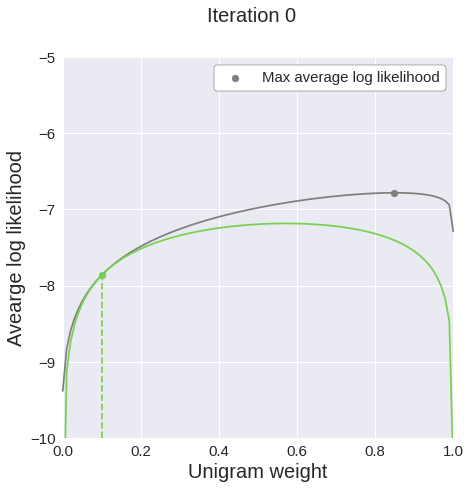

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')
ax.set_xlim(0, 1)
ax.set_ylim(-10, -5)

ax.legend(**legend_opts)
ax.set_xlabel('Unigram weight')
ax.set_ylabel('Avearge log likelihood')

anim = FuncAnimation(fig, lambda iteration: update_em(fig, ax, iteration), 
                     frames=range(n_iter), interval=300, repeat=True)
anim.save('../viz/em.mp4', writer='ffmpeg')

## Compare EM with gradient descent

In [36]:
def update_em_and_gd(fig, ax1, ax2, iteration):
    update_gd(fig, ax1, iteration)
    update_em(fig, ax2, iteration)

0
0
1
2
3
4
5
6
7
8
9
10
0


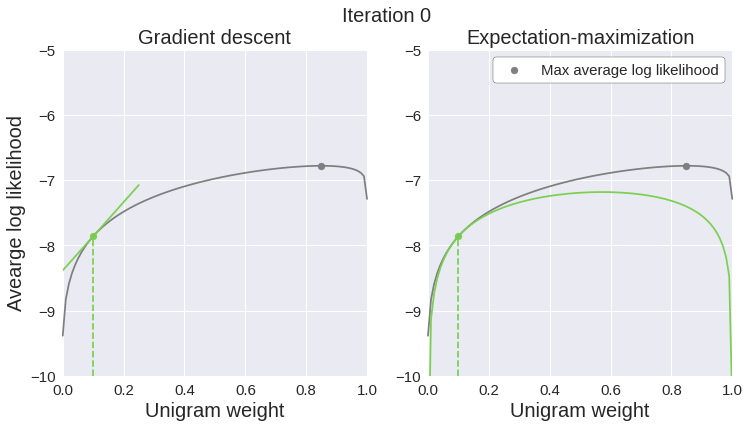

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax1.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')
ax1.set_xlim(0, 1)
ax1.set_ylim(-10, -5)
ax1.set_ylabel('Avearge log likelihood')
ax1.set_xlabel('Unigram weight')
ax1.set_title('Gradient descent')

ax2.plot(unigram_weights, dev_avg_lls, color='tab:gray', clip_on=False)
ax2.scatter(unigram_weights[np.argmax(dev_avg_lls)], np.max(dev_avg_lls), color='tab:gray', clip_on=False, label='Max average log likelihood')
ax2.set_xlim(0, 1)
ax2.set_ylim(-10, -5)

ax2.legend(**legend_opts)
ax2.set_xlabel('Unigram weight')
ax2.set_title('Expectation-maximization')

anim = FuncAnimation(fig, lambda iteration: update_em_and_gd(fig, ax1, ax2, iteration), 
                     frames=range(n_iter), interval=300, repeat=True)
anim.save('../viz/em_vs_gd.mp4', writer='ffmpeg')

### Plot EM vs gradient descent at various learning rates

Uniform-unigram interpolation

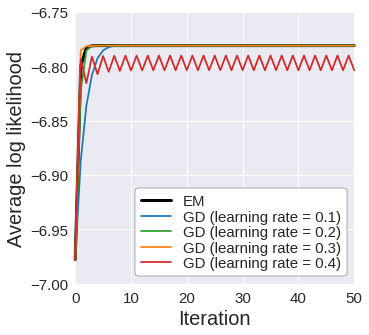

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))

n_iter = 51
learning_rates = [0.1, 0.2, 0.3, 0.4]
rate_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
iterations = list(range(n_iter))

# Plot average log likelihood during EM
em = EM()
em.fit(dev_prob_matrix[:, [0, 1]], n_iter=n_iter)
em_avg_lls = [em.tracked_info[iteration]['avg_ll'] for iteration in iterations]
ax.plot(iterations, em_avg_lls, color='black', lw=3, label='EM', clip_on=False)

# Plot average log likelihood during gradient descent (different learning rates)
for learning_rate, color in zip(learning_rates, rate_colors):
    gd = GradientDescent()
    gd.fit(dev_prob_matrix[:, [0, 1]], learning_rate=learning_rate, n_iter=n_iter)
    gd_avg_lls = [gd.tracked_info[iteration]['avg_ll'] for iteration in iterations]
    ax.plot(iterations, gd_avg_lls, color=color, label=f'GD (learning rate = {learning_rate})', clip_on=False)
    
ax.legend(**legend_opts, loc='lower right')
ax.set_xlabel('Iteration')
ax.set_ylabel('Average log likelihood')
ax.set_ylim(-7, -6.75)
ax.set_xlim(0, 50)
plt.show()

savefig(fig, 'em_gd_convergence_twomodel.png')

All model interpolation

/home/khanhnd/projects/ngram/analysis/ngram.py:133: RuntimeWarning: invalid value encountered in log
  average_log_likelihood = log_function(interpolated_probs).mean()


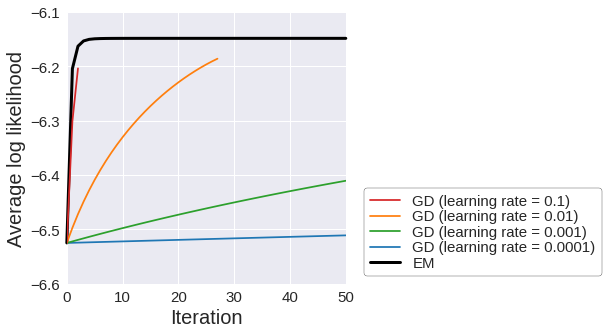

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))

n_iter = 51
learning_rates = [0.0001, 0.001, 0.01, 0.1]
rate_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
iterations = list(range(n_iter))

# Plot average log likelihood during EM
em = EM()
em.fit(dev_prob_matrix, n_iter=n_iter)
em_avg_lls = [em.tracked_info[iteration]['avg_ll'] for iteration in iterations]
ax.plot(iterations, em_avg_lls, color='black', lw=3, label='EM', clip_on=False)

# Plot average log likelihood during gradient descent (different learning rates)
for learning_rate, rate_color in zip(learning_rates, rate_colors):
    gd = GradientDescent()
    gd.fit(dev_prob_matrix, learning_rate=learning_rate, n_iter=n_iter)
    gd_avg_lls = [gd.tracked_info[iteration]['avg_ll'] for iteration in iterations]
    ax.plot(iterations, gd_avg_lls, color=rate_color, label=f'GD (learning rate = {learning_rate})')
    
ax.legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.04,0), loc='lower left', **legend_opts)

ax.set_xlabel('Iteration')
ax.set_ylabel('Average log likelihood')
ax.set_ylim(-6.6, -6.1)
ax.set_xlim(0, 50)
plt.show()

savefig(fig, 'em_gd_convergence_full.png')

## Result of EM

In [ ]:
n_iter = 11
em = EM()
em.fit(dev_prob_matrix, n_iter=n_iter)

iterations = list(range(n_iter))
em_avg_lls = [em.tracked_info[iteration]['avg_ll'] for iteration in iterations]
em_weight_percents = {}

ngram_lengths = list(range(6))
ngram_colors = ['tab:gray', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:red']
ngram_labels = ['Uniform', 'Unigram', 'Bigram', 'Trigram', '4-gram', '5-gram']
for ngram_length in ngram_lengths:
    em_weight_percents[ngram_length] = [em.tracked_info[iteration]['weights'][ngram_length]*100 for iteration in iterations]

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))
ax1.set_xticks(range(11))
ax1.set_xlim(0, 10)
ax1.set_ylim(-6.6, -6.1)
ax1.set_ylabel('Average log likelihood')


ax2.set_xlim(0, 10)
ax2.set_ylim(0, 50)
ax2.set_xticks(range(11))
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Interpolation weight (%)')


for ngram_length, ngram_color, ngram_label in zip(ngram_lengths, ngram_colors, ngram_labels):
    ax2.plot(iterations, em_weight_percents[ngram_length], color=ngram_color, marker='o', clip_on=False, label=ngram_label)
    
ax1.plot(iterations, em_avg_lls, color='black', marker='o', clip_on=False)

ax2.legend(**legend_opts, bbox_to_anchor=(1.04,0), loc='lower left')

savefig(fig, 'em_result.png')

In [ ]:
em.tracked_info[0]['avg_ll'], em.tracked_info[10]['avg_ll']

In [ ]:
em.tracked_info[n_iter-1]['weights'] * 100

## Compare EM result with average interpolation

In [ ]:
n_iter = 51
em = EM()
em.fit(dev_prob_matrix, n_iter=n_iter)

In [ ]:
test1_prob_matrix = np.load('../data/test1_prob_matrix.npy')
test2_prob_matrix = np.load('../data/test2_prob_matrix.npy')

In [ ]:
dev1_naive, dev1_em = calculate_avg_ln(dev1_prob_matrix), calculate_avg_ln(dev1_prob_matrix, em.weights)
dev2_naive, dev2_em = calculate_avg_ln(dev2_prob_matrix), calculate_avg_ln(dev2_prob_matrix, em.weights)
test1_naive, test1_em = calculate_avg_ln(test1_prob_matrix), calculate_avg_ln(test1_prob_matrix, em.weights)
test2_naive, test2_em = calculate_avg_ln(test2_prob_matrix), calculate_avg_ln(test2_prob_matrix, em.weights)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylim(-7, -5.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Equal\nweights', 'EM-optimized\nweights'])
ax.set_ylabel('Average log likelihood')

ax.plot([0, 1], [dev1_naive, dev1_em], color='tab:blue', marker='o')
ax.plot([0, 1], [dev2_naive, dev2_em], color='tab:green', marker='o')
ax.plot([0, 1], [test1_naive, test1_em], color='tab:cyan', marker='o')
ax.plot([0, 1], [test2_naive, test2_em], color='tab:olive', marker='o')

savefig(fig, 'em_vs_equal.png')

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylim(-7, -5.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Equal\nweights', 'EM-optimized\nweights'])
ax.set_ylabel('Average log likelihood')

ax.plot([0, 1], [dev1_naive, dev1_em], color='tab:blue', marker='o')
ax.plot([0, 1], [dev2_naive, dev2_em], color='tab:green', marker='o')
ax.plot([0, 1], [test1_naive, test1_em], color='tab:cyan', marker='o')
ax.plot([0, 1], [test2_naive, test2_em], color='tab:olive', marker='o')

savefig(fig, 'em_vs_equal.png')

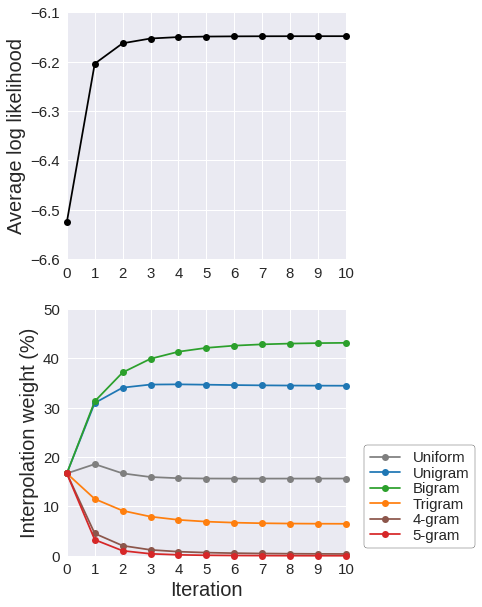

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))
ax1.set_xticks(range(11))
ax1.set_xlim(0, 10)
ax1.set_ylim(-6.6, -6.1)
ax1.set_ylabel('Average log likelihood')


ax2.set_xlim(0, 10)
ax2.set_ylim(0, 50)
ax2.set_xticks(range(11))
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Interpolation weight (%)')


for ngram_length, ngram_color, ngram_label in zip(ngram_lengths, ngram_colors, ngram_labels):
    ax2.plot(iterations, em_weight_percents[ngram_length], color=ngram_color, marker='o', clip_on=False, label=ngram_label)
    
ax1.plot(iterations, em_avg_lls, color='black', marker='o', clip_on=False)

ax2.legend(**legend_opts, bbox_to_anchor=(1.04,0), loc='lower left')

savefig(fig, 'em_result.png')

In [42]:
em.tracked_info[0]['avg_ll'], em.tracked_info[10]['avg_ll']

(-6.524851772982703, -6.148502511394851)

In [43]:
em.tracked_info[n_iter-1]['weights'] * 100

array([1.56313140e+01, 3.44153007e+01, 4.30944132e+01, 6.47738818e+00,
       3.70859443e-01, 1.07244992e-02])

## Compare EM result with average interpolation

In [44]:
n_iter = 51
em = EM()
em.fit(dev_prob_matrix, n_iter=n_iter)

In [45]:
test1_prob_matrix = np.load('../data/test1_prob_matrix.npy')
test2_prob_matrix = np.load('../data/test2_prob_matrix.npy')

In [46]:
dev1_naive, dev1_em = calculate_avg_ln(dev1_prob_matrix), calculate_avg_ln(dev1_prob_matrix, em.weights)
dev2_naive, dev2_em = calculate_avg_ln(dev2_prob_matrix), calculate_avg_ln(dev2_prob_matrix, em.weights)
test1_naive, test1_em = calculate_avg_ln(test1_prob_matrix), calculate_avg_ln(test1_prob_matrix, em.weights)
test2_naive, test2_em = calculate_avg_ln(test2_prob_matrix), calculate_avg_ln(test2_prob_matrix, em.weights)

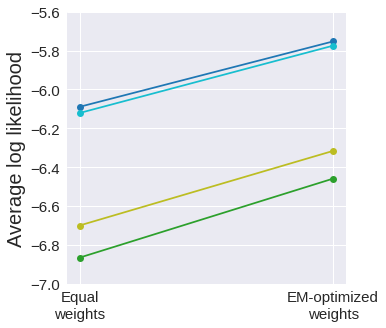

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_ylim(-7, -5.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Equal\nweights', 'EM-optimized\nweights'])
ax.set_ylabel('Average log likelihood')

ax.plot([0, 1], [dev1_naive, dev1_em], color='tab:blue', marker='o')
ax.plot([0, 1], [dev2_naive, dev2_em], color='tab:green', marker='o')
ax.plot([0, 1], [test1_naive, test1_em], color='tab:cyan', marker='o')
ax.plot([0, 1], [test2_naive, test2_em], color='tab:olive', marker='o')

savefig(fig, 'em_vs_equal.png')